### MTF Report

In [1]:
%matplotlib inline
from enum import Enum, auto
from warnings import warn

import matplotlib.pyplot as plt

import numpy as np
from numpy.fft import rfft, fftshift, fft
import pandas as pd

from scipy.special import erf, erfc, sici
from scipy.optimize import curve_fit
from scipy.signal import hamming
from scipy.interpolate import interp1d

from skimage.morphology import binary_erosion, binary_dilation, disk
from skimage.feature import canny
from skimage.transform import hough_line, hough_line_peaks
from skimage.filters import sobel

import statsmodels.api as sm
lowess = sm.nonparametric.lowess

import pydicom as dcm

from dcmfetch import fetch_series

from mriqa.phantoms import find_phantom, PIQTMTF, PIQTSNR, TO4
from mriqa.tools import show_mosaic, all_ims, image_from_dicom
from mriqa.dcmio import number_of_frames, pix_spacing_yx, seq_name, series_number, approx_phase_orientation

### Help functions to select the region of interest of MTF block

In [2]:
def _get_rect_roi(image, pixdims, rect, centre):
    """
    Extract a rectangular region of interest from an image.

    The rectangle is specified as (x, y, dx, dy) in mm.
    The region of interest is shifted according to the specified
    phantom centre (NB in pixels). The returned ROI is a view
    on the original image array.
    """

    def _get_rect_roi_coords(pixdims, rect, centre):
        """
        Get indices and offsets of a rectangle ROI.

        The rectangle is specified as (x, y, dx, dy) in mm.
        The ROI is shifted according to specified phantom centre (NB in pixels).
        The returned specification (x, y, dx, dy) is in (integer) pixels.
        TODO: do we need to do off by 0.5 fix?
        TODO: Cf convention in dicom/skimage/matplotlib)
        """
        centre_x, centre_y = centre
        (x, y), (dx, dy) = np.round((np.array(rect) / pixdims)).astype('int')
        x += centre_x
        y += centre_y
        return x, y, dx, dy

    x, y, dx, dy = _get_rect_roi_coords(pixdims, rect, centre)
    return image[y:y+dy, x:x+dx]

### Get subregions round each of the four edges

In [3]:
def mtf_block_edges(roi):
    """
    Strongest four lines in ROI corresponding to the four edges of the mtf block
    
    Parameters
    ----------
    roi: ndarray (2d)
        image containing mtf block
    
    Returns
    -------
    
    tuple list of angles and list of distances 
    """
    def centre_angle(roi, theta, dist):
        """
        Angle around image centre to sort edges by
        """
        theta = np.pi/2 - theta
        if dist > np.hypot(*np.array(roi.shape) / 2):
            theta += np.pi
        return np.mod(theta, 2*np.pi)

    mask = roi > roi.mean()
    mask = binary_dilation(mask, disk(3)) & ~binary_erosion(mask, disk(3))
    edges = mask & canny(roi/roi.mean(), sigma=3) & mask

    # Hough Line Tranform
    tested_angles = np.r_[
        np.linspace(-np.pi / 8, np.pi / 8, 60),
        np.linspace(3*np.pi / 8, 5*np.pi / 8, 60)

    ]
    h, theta, d = hough_line(edges, theta=tested_angles)

    # Pick 4 best lines
    peaks = hough_line_peaks(h, theta, d, threshold=0.4*h.max(), num_peaks=4)
    print('no of peaks =', len(peaks[0]))
    x0_x1 = np.array([0, roi.shape[1]])

    angles, dists = peaks[1][:4], peaks[2][:4]
    
    # Sort around centre of block
    angles, dists = zip(*sorted(
        zip(angles, dists),
        key=lambda pair: centre_angle(roi, pair[0], pair[1])
    ))
    return angles, dists

def intersection(line1, line2):
    """
    Intersection of two lines in Hesse normal form.
    See https://stackoverflow.com/a/383527/5087436
    
    Parameters
    ----------
    line1: pair of float
        first line expressed as angle and distance
    line2: pair of float
        second line expressed as angle and distance
    Returns
    -------
        Coordinates of intersection (x, y)
    """
    theta1, rho1 = line1
    theta2, rho2 = line2
    A = np.array([
        [np.cos(theta1), np.sin(theta1)],
        [np.cos(theta2), np.sin(theta2)]
    ])
    b = [rho1, rho2]

    x0, y0 = np.linalg.solve(A, b)
    return x0, y0


def mtf_block_subrois(roi, angles, dists):
    """
    ROIs for the four edges of the mtf block.
    
    The ROIs are reoriented so as to all have the edge in the same position
    and returned in a dictionary.
    
    Parameters
    ----------
    roi: ndarray (2d)
        image containing mtf block
    angles: ndarray (1d)
       angles of mtf block edges
    dists: ndarray (1d)
       distances of mtf block edges
    
    Returns
    -------
    dictionary of sub regions

    """

    def extract_bbox(line1, line2, line3):
        p1 = np.array(intersection(line1, line2))
        p2 = np.array(intersection(line1, line3))
        ps = np.array([p1, p2])

        return np.array([
            np.min(ps, axis=0),
            np.max(ps, axis=0)
        ])

    ny, nx = roi.shape
    print(angles)
    # NB hough angle defined such that 0 is vertical 90 is horizontal
    horiz_angles, horiz_dists = zip(*[(angle, dist) for angle, dist in zip(angles, dists) if abs(np.degrees(angle)) > 45])
    vert_angles, vert_dists = zip(*[(angle, dist) for angle, dist in zip(angles, dists) if abs(np.degrees(angle)) <= 45])
    print('horiz:', len(horiz_angles), 'vert:', len(vert_angles))
    subrois = {}
    # horizontal edges
    for horiz_angle, horiz_dist in zip(horiz_angles, horiz_dists):
        line1 = horiz_angle, horiz_dist
        line2 = vert_angles[0], vert_dists[0]
        line3 = vert_angles[1], vert_dists[1]

        bbox = extract_bbox(line1, line2, line3)
        print(f'Horiz BBox: width={bbox[1][1]-bbox[0][1]}, height={bbox[1][0]-bbox[0][0]}')

        line_segment_length = np.hypot(*(bbox[1] - bbox[0]))
        print(line_segment_length)
        bbox[0] -= (-line_segment_length/10, 15)
        bbox[1] += (-line_segment_length/10, 15)

        bbox = np.round(bbox).astype(int)
        print(f'Horiz BBox: width={bbox[1][1]-bbox[0][1]}, height={bbox[1][0]-bbox[0][0]}')
        bbox = np.clip(bbox, 0, None)
        bbox[1][0] = np.clip(bbox[1][0], None, nx-1)
        bbox[1][1] = np.clip(bbox[1][1], None, ny-1)
        
        subroi = roi[bbox[0][1]:bbox[1][1], bbox[0][0]:bbox[1][0]]
        profile = subroi.sum(axis=1)
        if profile[-1] > profile[0]:
            subrois['Top'] = subroi
        else:
            subrois['Bottom'] = np.rot90(subroi, 2)
    
    # vertical edges
    for vert_angle, vert_dist in zip(vert_angles, vert_dists):
        line1 = vert_angle, vert_dist
        line2 = horiz_angles[0], horiz_dists[0]
        line3 = horiz_angles[1], horiz_dists[1]

        bbox = extract_bbox(line1, line2, line3)
        print(f'Vert BBox: width={bbox[1][1]-bbox[0][1]}, height={bbox[1][0]-bbox[0][0]}')
        
        # shrink along edge and grow perpendicular
        bbox[0] += (-line_segment_length/10, 15)
        bbox[1] -= (-line_segment_length/10, 15)

        bbox = np.round(bbox).astype(int)
        print(f'Vert BBox: width={bbox[1][1]-bbox[0][1]}, height={bbox[1][0]-bbox[0][0]}')
        bbox = np.clip(bbox, 0, None)
        bbox[1][0] = np.clip(bbox[1][0], None, nx-1)
        bbox[1][1] = np.clip(bbox[1][1], None, ny-1)

        subroi = roi[bbox[0][1]:bbox[1][1], bbox[0][0]:bbox[1][0]]
        profile = subroi.sum(axis=0)
        if profile[-1] > profile[0]:
            subrois['Right'] = np.rot90(subroi, 3)
        else:
            subrois['Left'] = np.rot90(subroi, 1)

    return subrois

### Fit model to Edge

In [4]:
def initial_edge_fit(roi, method=sobel):
    """
    Initial fit to mtf block edge in image using edge detection.
    
    Parameters
    ----------
    roi: ndarray (2d)
        image containing a single mtf block edge
    method: [Optional] function
        edge detection function to use

    Returns
    -------
    tuple - slope and intercept of detected line
    """
    edges = method(roi)
    points = []
    for i, col in enumerate(edges.T):
        x, y = i, np.argmax(col)
        points.append((x, y))
    X, Y = np.asarray(points).T
    X, Y = X[1:-1], Y[1:-1]
    slope, intercept = np.polyfit(X, Y, deg=1)
    return slope, intercept


def roi_model_erf(XY, i0, i1, a, b, c, d, e, f, sigma, intercept, slope):
    """
    Function to model an edge in the mtf block.
    
    This is a linear fit to the edge position and an error function blurring of the edge.
    A quadratic bias field for the image intensities is also allowed.
    
    Parameters
    ----------
    XY:
        x and y coordinates of positions in the roi
    i0, i1: float, float
        backgound and foreground intensity
    a, b, c, d, e, f:
        quadratic gain field
    sigma:
        width of error function at edge
    intercept, slope:
        line passing through edge

    Returns
    -------
        flattened predicted image
    """
    x, y = XY
    # Quadratic model of bias field
    gain = a + b*x + c*y + d * x**2 + e * y**2 + f * x*y
    # Linear model of edge position
    loc = intercept + x * slope
    # Complementary error function model of edge transition
    result =  gain * (i0 + (i1 - i0) * phi((y - loc) / sigma))
    # Function curve_fit() needs the image flattened to 1D
    return result.ravel()

def roi_model_magsi(XY, i0, i1, a, b, c, d, e, f, sigma, intercept, slope):
    """
    Function to model an edge in the mtf block.
    
    This is a linear fit to the edge position and rectified sine integral blurring of the edge.
    A quadratic bias field for the image intensities is also allowed.
    
    Parameters
    ----------
    XY:
        x and y coordinates of positions in the roi
    i0, i1: float, float
        backgound and foreground intensity
    a, b, c, d, e, f:
        quadratic gain field
    sigma:
        width of error function at edge
    intercept, slope:
        line passing through edge

    Returns
    -------
        flattened predicted image
    """
    si = lambda x: 0.5 + sici(np.pi * x)[0] / np.pi
    x, y = XY
    # Quadratic model of bias field
    gain = a + b*x + c*y + d * x**2 + e * y**2 + f * x*y
    # Linear model of edge position
    loc = intercept + x * slope
    # Sine integral function model of edge transition with abs() rectification
    result =  abs(gain * (i0 + (i1 - i0) * si((y - loc) / sigma)))
    # Function curve_fit() needs the image flattened to 1D
    return result.ravel()


def fit_model(roi, model):
    """
    Non-linear least squares fit of model to an mtf block edge in an image.
    
    Gives an estimate of the edge position and inclination as well as a bias
    field correction to apply to the images in further analysis,

    Parameters
    ----------
    roi: ndarray (2d)
        image with single mtf block edge
    model: function
        model to fit
    Returns
    -------
        tuple - slope and intercept of edge and bias field image.
    """
    # Coordinates
    X, Y = np.meshgrid(np.arange(roi.shape[1]), np.arange(roi.shape[0]))

    # Starting Point:
    # Assume bottom right and top left representative of foreground and background
    # uniform gain and a one pixelwidth edge 
    # edge position and slope from edge detection 
    i0_0 = roi[:10, :10].mean() 
    i1_0 = roi[-10:, -10:].mean()
    a_0 = 1.0; b_0 = c_0 = d_0 = e_0 = f_0 = 0.0
    sigma_0 = 1.0
    slope_0, intercept_0 = initial_edge_fit(roi)

    p0 = [i0_0, i1_0, a_0, b_0, c_0, d_0, e_0, f_0, sigma_0, intercept_0, slope_0]

    # Data to fit
    popt, pcov = curve_fit(model, xdata=(X, Y), ydata=roi.flatten(), p0=p0)
    i0, i1, a, b, c, d, e, f, sigma, intercept, slope = popt

    gain_field = a + b*X + c*Y + d * X**2 + e * Y**2 + f * X*Y
    return slope, intercept, gain_field

### Extract Profile

In [5]:
class Orientation(Enum):
    VERTICAL = auto()
    HORIZONTAL = auto()
    
def edge_profile_from_roi(roi, pixdims, model=roi_model_magsi, orientation=Orientation.VERTICAL):
    """
    Return irregularly sampled edge response from image consisting of a horizontal ROI around the edge.
    
    Assumes the edge also appears approximately horizontal in the image, rising left to right and bright at the bottom.
    
    Parameters
    ----------
    roi: ndarray (2d)
        image array of single edge
    pixdims: tuple of float
        pixel dimensions (y, x)
    model: function (optional)
        modelling function (default is error in along straight edge with bias field correction)    
    orientation: enum (optional)
        use horizontal or vertical edge distances
    
    Returns
    -------
    tuple of x-positions and signal values
    """
    
    assert roi.shape[1] > roi.shape[0]
    assert roi.mean(axis=1)[-1] > roi.mean(axis=1)[0]
    assert roi.mean(axis=0)[-1] > roi.mean(axis=0)[0]
    assert len(pixdims) == 2
    
    X, Y = np.meshgrid(np.arange(roi.shape[1]), np.arange(roi.shape[0]))
    nrows, ncols = roi.shape
    slope, intercept, gain_field = fit_model(roi.astype(float), model)
    # normalise and flatten
    pixvals = (roi / gain_field).ravel()
    
    # Which way across the edge .. it doesn't seem to make any difference
    if orientation is Orientation.VERTICAL:
        y_shifts_at_x = np.arange(ncols) * slope + intercept
        Y_shifted = (Y - y_shifts_at_x[X]).ravel()
        sort_order_col = np.argsort(Y_shifted)
        proj_factor_col = np.abs(np.cos(np.arctan(slope)))
        effective_pixel_size_col = pixdims[0] * proj_factor_col    
        locns_mm, vals_at_locns = Y_shifted[sort_order_col]  * effective_pixel_size_col, pixvals[sort_order_col]
    elif orientation is Orientation.HORIZONTAL:
        x_shifts_at_y = (np.arange(nrows) - intercept) / slope
        X_shifted = (X - x_shifts_at_y[Y]).ravel()
        sort_order_row = np.argsort(X_shifted)
        proj_factor_row = np.abs(np.sin(np.arctan(slope)))
        effective_pixel_size_row = pixdims[1] * proj_factor_row
        locns_mm, vals_at_locns = X_shifted[sort_order_row] * effective_pixel_size_row, pixvals[sort_order_row]
    else:
        raise ValueError('Illegal value for orientation')

    # Normalise to unit range; curve is rising from minumum at start
    npoints = len(vals_at_locns)
    lower = vals_at_locns[:npoints//3].mean()
    upper = vals_at_locns[2*npoints//3:].mean()
    return locns_mm, (vals_at_locns - lower) / (upper - lower)


def lowess_regrid(x_mm, esf, margin=1.75):
    """
    Regrid edge spread function after smoothing with loess.
    
    Parameters
    ----------
    x_mm: ndarray (1d)
        x axis for esf in mm
    
    esf: ndarray (1d)
        esf defined at x locations
    margin: float
        region around edge to consider for esf (mm)
    
    Returns
    -------
    line response function: ndarray (1d)

    """
    # Trim down
    window = (-margin < x_mm) & (x_mm < margin)
    esf = esf[window]
    x_mm = x_mm[window]

    x = x_mm
    y = esf - esf.mean()

    # Lowess fit on irregular grid
    assert(list(x) == sorted(x))
    w = lowess(y, x, frac=0.05, return_sorted=False)

    # Interpolate onto a regular grid
    f = interp1d(x, w, kind='cubic')
    x_grid = np.linspace(x.min(), x.max(), 512)
    w_grid = f(x_grid)
    return x_grid, w_grid + esf.mean()

### Extraction of lsf and mtf

In [6]:
def lsf_from_esf(x_mm, esf):
    """
    Derive line response by differentiating edge response and applying window.
    
    Parameters
    ----------
    x_mm: ndarray (1d)
        x axis for esf and lsf in mm
    
    esf: ndarray (1d)
        esf defined at x locations
    
    Returns
    -------
    line response function: ndarray (1d)

    """
    grid_spacing = x_mm[1] - x_mm[0]
    lsf = np.gradient(esf, grid_spacing)
    return lsf * hamming(len(lsf))


def mtf_from_lsf(x_mm, lsf):
    """
    Derive modulation transfer function by Fourier transforming edge response.
    
    MTF is normalised to unity at zero frequency.
    
    Parameters
    ----------
    x_mm: ndarray (1d)
        x axis for lsf in mm
    
    lsf: ndarray (1d)
        lsf defined at x locations
    
    Returns
    -------
    modulation transfer function: ndarray (1d)

    """
    npoints = len(lsf)

    mtf = np.abs(rfft(np.pad(lsf, npoints//2, mode='constant')))
    if mtf.argmax() != 0:
        warn("MTF maximum is not at zero")
    mtf /= mtf[0]

    effective_pixel_size = x_mm[1] - x_mm[0]
    
    # Check this - we are working in mm
    x_mtf = np.arange(2*len(mtf)) / npoints / effective_pixel_size / 2
    
    # Normalized to maximum at DC
    return x_mtf, mtf / mtf[0]


def mtf_edge_analysis(roi, pixdims, model=roi_model_magsi):
    """
    Analysis of single edge of mtf block.
    
    Assumes edge is positive going top to bottom and is at a shallow positive angle.

    Parameters
    ----------
    roi: ndarray (2d)
        image array containing single edge of mtf block
    pixdims: tuple of float
        pixels sizes (y, x)
    model: function (optional)
        modelling function (default is error in along straight edge with bias field correction)
    
    Returns
    -------
    tuple of results from edge analysis
    """

    x_mm, esf = edge_profile_from_roi(roi, pixdims, model=model)
    x_mm_grid, esf_grid = lowess_regrid(x_mm, esf)

    lsf = lsf_from_esf(x_mm_grid, esf_grid)
    x_mtf, mtf = mtf_from_lsf(x_mm_grid, lsf)

    return x_mm, esf, x_mm_grid, esf_grid, lsf, x_mtf, mtf


### Reports

In [7]:
def piqt_mtf_report(
    mtf_dobj, centring_dobj=None,
    mtf_frame=None, centring_frame=None,
    mtf_phantom=PIQTMTF, centring_phantom=PIQTSNR,
    cutoff_freq=3.0, fliplr=False, flipud=False, block_index=0):
    """
    Resolution Report based on MTF block in PIQT phantom.

    Parameters
    ----------
    mtf_dobj: dicom object
        slice or multiframe with mtf block
    centring_dobj: [Optional] dicom object
        slice or multiframe with SNR region for phantom centring
    mtf_frame: [Optional] int
        frame number of mtf image if multiframe
    centring_frame: [Optional] int
        frame number of centring image if multiframe
    mtf_phantom: [Optional] dict
        phantom description of mtf image
    centring_phantom: [Optional] dict
        phantom description of centring image
    cutoff_freq: [Optional] float
        maximum spatial frequency to consider in mtf in cycles/mm

    Returns
    -------
    Dataframe with 50% maximum frequency of mtf for each edge
    
    TODO: Allow specification of subset of edges
    """

    def find_index(x, value):
        return np.diff(np.sign(x - value)).nonzero()[0][0] 

    def half_max(x, y):
        x_interp = np.linspace(x[0], x[-1], 50)
        y_interp = interp1d(x, y)(x_interp)
        return x_interp[(abs(y_interp - 0.5)).argmin()]

    mtf_image = image_from_dicom(mtf_dobj, mtf_frame)
    centring_image = image_from_dicom(
        centring_dobj if centring_dobj is not None else mtf_dobj,
        centring_frame
    ) 

    if fliplr:
        mtf_image = np.fliplr(mtf_image)
        centring_image = np.fliplr(centring_image)

    if flipud:
        mtf_image = np.flipud(mtf_image)
        centring_image = np.flipud(centring_image)

    # Voxel geometry - require square pixels for now
    dy, dx = pixdims = pix_spacing_yx(mtf_dobj)
    assert np.isclose(dx, dy)
    
    # find_phantom returns pixel coordinates in natural order (x, y)
    expected_radius = centring_phantom['Diameter'] / 2 / dx
    centre_x, centre_y, radius = find_phantom(centring_image, expected_radius)
    centre = centre_x, centre_y

    # ROI for all of mtf block
    block = mtf_phantom['Features']['Blocks'][block_index]
    roi = _get_rect_roi(mtf_image, pixdims=pixdims, rect=block, centre=centre)

    # Extract subroi for each edge
    angles, dists = mtf_block_edges(roi)
    print('found ', len(angles), 'lines')
    subrois = mtf_block_subrois(roi, angles, dists)
    
    # Perform edge analyses
    analyses = {name: mtf_edge_analysis(roi, pixdims, model=roi_model_magsi) for (name, roi) in subrois.items()}
    halfmaxima = {}
    for name in analyses:
        x_mm, esf, x_mm_grid, esf_grid, lsf, x_mtf, mtf = analyses[name]
        cutoff_index = find_index(x_mtf, cutoff_freq)
        halfmaxima[name] = half_max(x_mtf[:cutoff_index+1], mtf[:cutoff_index+1])


    (x, y), (width, height) = np.array(block) / pixdims

    # TODO: are we missing an off-by-one adjustment here?
    x += centre_x
    y += centre_y
    x = int(round(x))
    y = int(round(y))

    # Plot results
    fig, axs = plt.subplots(2, 2, figsize=(12, 9))
    axs = axs.ravel()
    
    # Image
    ax = axs[0]
    ax.imshow(mtf_image, cmap='bone')
    ax.axis('off')
    ax.grid(False)
    nrows, ncols = mtf_image.shape

    ax.axvline(centre_x, linewidth=0.5, color='C1')
    ax.axhline(centre_y, linewidth=0.5, color='C1')
    ax.add_artist(
        plt.Circle((centre_x, centre_y), radius, color='C1', fill=False)
    )
    ax.text(x, y, '({}, {})'.format(x, y), color='C2')
    ax.add_artist(
        plt.Rectangle((x, y), width, height, color='C2', fill=False, linewidth=0.5)
    )
    ax.vlines([x+dx/2], y, y+height, color='C2', linewidth=0.5)
    ax.hlines([y+dy/2], x, x+width, color='C2', linewidth=0.5)
    
    ax.set_title(
        r'Series %d, Image %d, %0.1fx%0.1fmm (%s)' %
        (series_number(mtf_dobj), mtf_dobj.InstanceNumber, dy, dx, approx_phase_orientation(mtf_dobj))
    )
    # MTF Analysis
    for name in analyses:
        x_mm, esf, x_mm_grid, esf_grid, lsf, x_mtf, mtf = analyses[name]
        ax = axs[1]
        ax.plot(x_mm, esf, '.', markersize=2)
        ax.plot(x_mm_grid, esf_grid, label=name)    
        ax.set_xlim(x_mm_grid[0], x_mm_grid[-1])
        
        ax = axs[2]
        ax.plot(x_mm_grid, lsf, label=name)    
        ax.set_xlim(x_mm_grid[0], x_mm_grid[-1])

        ax = axs[3]
        cutoff_index = find_index(x_mtf, cutoff_freq)
        x_mtf, mtf = x_mtf[:cutoff_index+1], mtf[:cutoff_index+1]
        halfmax = halfmaxima[name]
        p = ax.plot(x_mtf, mtf, label='%s: %0.2f' % (name, halfmax))
        ax.vlines(halfmax, 0, 0.5, color=p[0].get_color(), linewidth=1, linestyle='dotted')

    ax = axs[1]
    ax.grid(True)
    ax.set_xlabel('Distance from Edge (mm)')
    ax.set_ylabel('Normalised Brightness')
    ax.set_title('Fitted Edge Spread Function')
    ax.legend()
    
    ax = axs[2]
    ax.grid(True)
    ax.set_xlabel('Distance from Edge (mm)')
    ax.set_title('Line Spread Function (Windowed)')
    ax.legend()
    
    ax = axs[3]
    ax.set_xlim(0, cutoff_freq)
    ax.grid(True)
    ax.set_xlabel('Spatial Frequency (cycles per mm)')
    ax.set_ylabel('Modulation Depth')
    ax.set_title('Modulation Transfer Function')
    ax.axhline(0.5, linewidth=1, color='black', linestyle='dotted')
    ax.legend()
    fig.suptitle('Resolution [%s]' % seq_name(mtf_dobj), fontsize=16)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

    # need to add code to calculate FWHM of line response and similar from MTF
    return pd.DataFrame({'MTF_HalfMax': halfmaxima}, index=subrois.keys())    

----

no of peaks = 4
found  4 lines
(1.391086577542938, -0.1797097492519585, -0.1797097492519585, 1.391086577542938)
horiz: 2 vert: 2
Horiz BBox: width=18.410632465645342, height=101.34124832571842
103.00000000000001
Horiz BBox: width=48, height=81
Horiz BBox: width=18.410632465645335, height=101.3412483257184
102.99999999999999
Horiz BBox: width=48, height=80
Vert BBox: width=101.34124832571841, height=18.410632465645307
Vert BBox: width=71, height=39
Vert BBox: width=101.3412483257184, height=18.410632465645328
Vert BBox: width=71, height=39


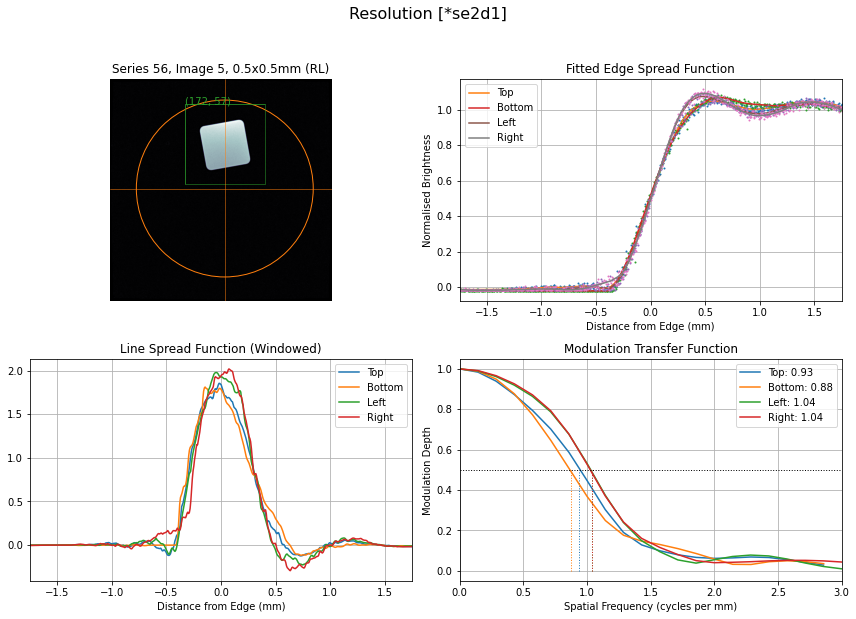

MTF_HalfMax
Top        0.933053
Bottom     0.875297
Left       1.040419
Right      1.040676

In [8]:
# Multislice PIQT phantom scan
dobjs = fetch_series(patid='PQA20181213BCH3Y', stuid='1', sernos=[56])
x = piqt_mtf_report(dobjs[4], dobjs[2])
plt.show()
x

----

TO4 is different in that:
 - negative contrast
 - two blocks
 - no curved edges

no of peaks = 4
found  4 lines
(1.3777747442650152, -0.19302158252988136, 1.3777747442650152, -0.19302158252988136)
horiz: 2 vert: 2
Horiz BBox: width=31.65116380239109, height=161.93580156949298
165.0
Horiz BBox: width=61, height=129
Horiz BBox: width=31.651163802391096, height=161.93580156949298
165.0
Horiz BBox: width=61, height=129
Vert BBox: width=161.935801569493, height=31.65116380239109
Vert BBox: width=132, height=64
Vert BBox: width=161.935801569493, height=31.651163802391096
Vert BBox: width=132, height=64


/tmp/ipykernel_21808/2154131755.py:46: UserWarning: MTF maximum is not at zero
  warn("MTF maximum is not at zero")


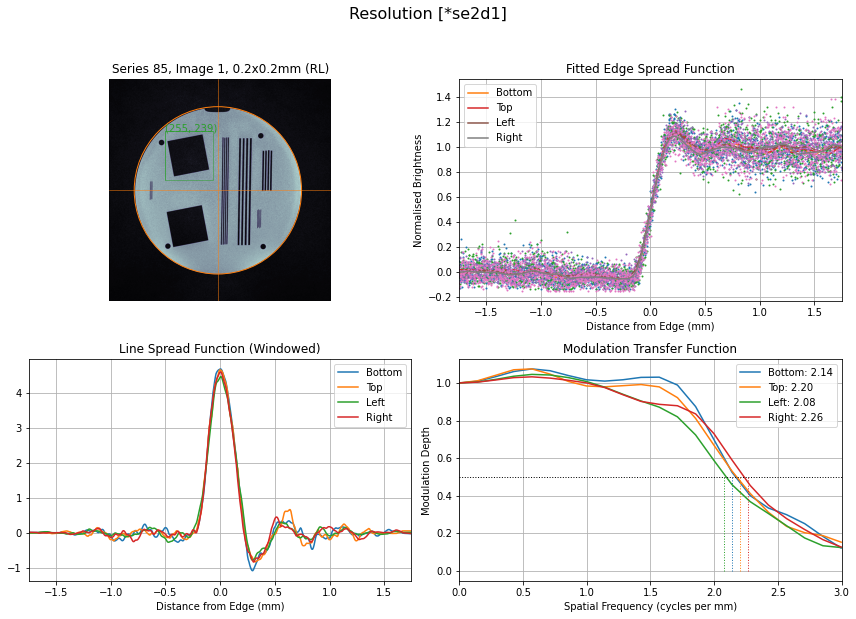

In [9]:
patid = 'PQA20140807SC'
stuid = '3'
sernos = [85]
dobjs = fetch_series(patid, stuid, sernos)
x = piqt_mtf_report(dobjs[0], dobjs[0], mtf_phantom=TO4, centring_phantom=TO4, fliplr=True)

no of peaks = 4
found  4 lines
(1.3777747442650152, -0.1797097492519585, 1.3777747442650152, -0.1797097492519585)
horiz: 2 vert: 2
Horiz BBox: width=31.653968380208624, height=161.95015053813697
165.01462048418762
Horiz BBox: width=61, height=129
Horiz BBox: width=31.653968380208596, height=161.950150538137
165.01462048418765
Horiz BBox: width=62, height=129
Vert BBox: width=161.3731786775762, height=29.31661422698098
Vert BBox: width=132, height=62
Vert BBox: width=161.37317867757622, height=29.316614226980988
Vert BBox: width=131, height=62


/tmp/ipykernel_21808/2154131755.py:46: UserWarning: MTF maximum is not at zero
  warn("MTF maximum is not at zero")


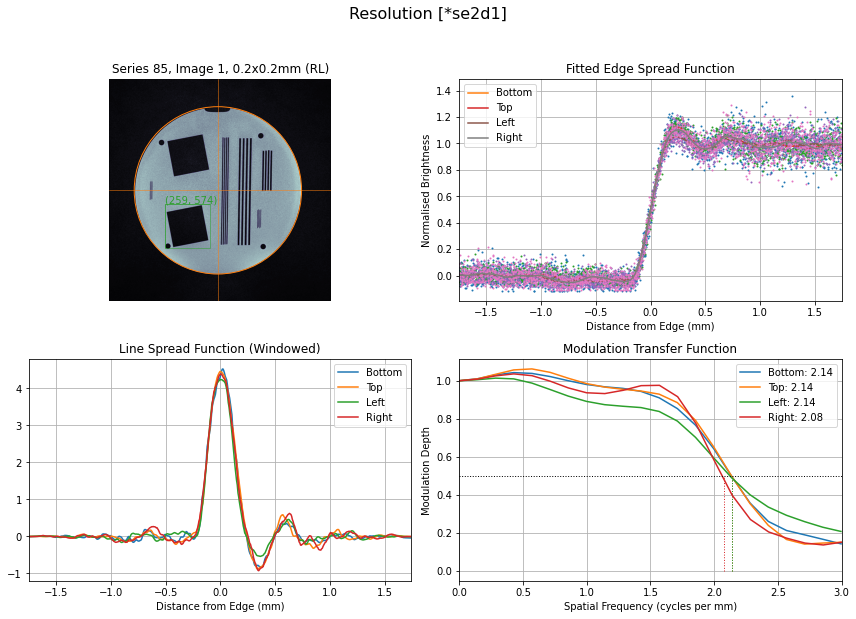

In [10]:
patid = 'PQA20140807SC'
stuid = '3'
sernos = [85]
dobjs = fetch_series(patid, stuid, sernos)
x = piqt_mtf_report(dobjs[0], dobjs[0], mtf_phantom=TO4, centring_phantom=TO4, fliplr=True, block_index=1)